# Read data

In [2]:
import pandas as pd

movies = pd.read_csv('data/movies_meta_data.csv', sep=';', engine='python')
users = pd.read_csv('data/users.dat', sep='::', engine='python', names=['userId', 'gender', 'age', 'occupation', 'zip-code'])
ratings = pd.read_csv('data/ratings.dat', sep='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])

<Axes: title={'center': 'Gender distribution'}>

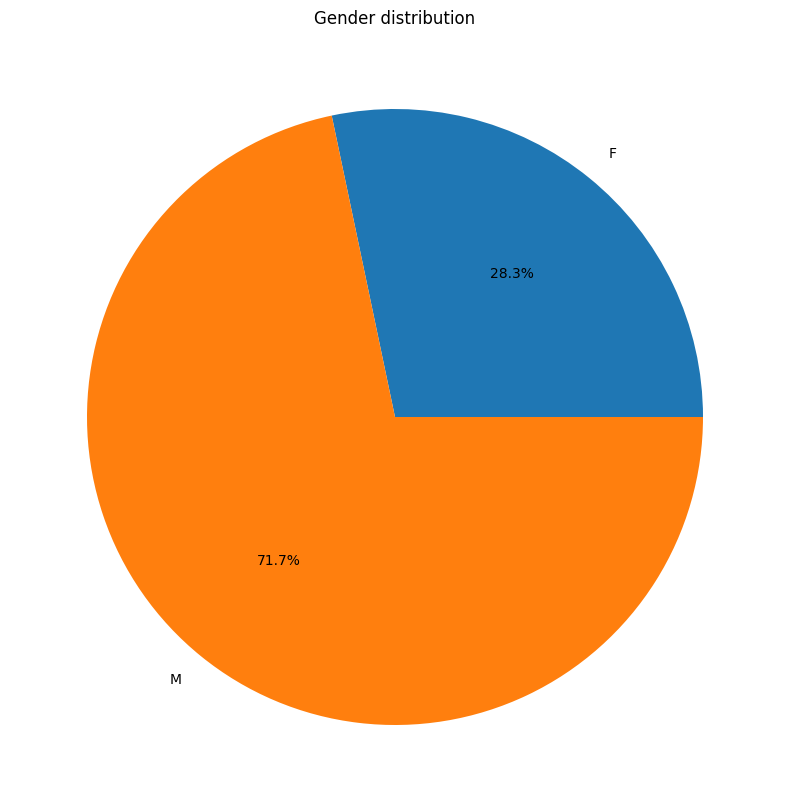

In [3]:
users.groupby('gender').size().plot(kind='pie', y=0, figsize=(10, 10), autopct='%1.1f%%', title='Gender distribution')




In [4]:
ratings.groupby('userId').size()

userId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

<Axes: title={'center': 'Number of ratings per user'}, ylabel='Frequency'>

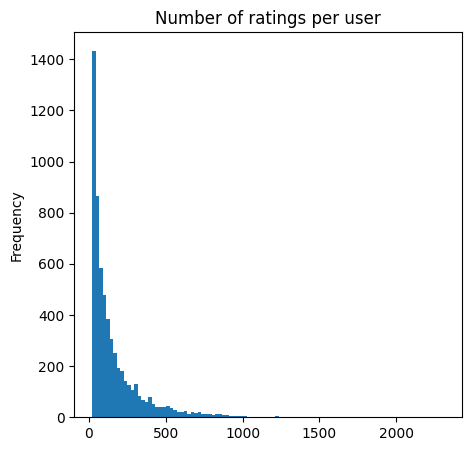

In [5]:
ratings.groupby('userId').size().plot(kind='hist', bins=100, figsize=(5, 5), title='Number of ratings per user', xlabel='Number of ratings', ylabel='Number of users')

# Cleaning

As we don't plan on doing anything with the zip code of the user we will drop this feature.

In [6]:
users_dropped = users.drop(['zip-code'], axis=1)

Because the timestamp adds no value to our model we are going to remove the timestamp from all ratings.

In [7]:
ratings_dropped = ratings.drop('timestamp', axis=1)

In [8]:
movies_dropped = movies[['ml_movieId', 'Title', 'Year', 'Released', 'Runtime', 'Genre', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice']]
movies_dropped.head()

,ml_movieId,Title,Year,Released,Runtime,Genre,Ratings,Metascore,imdbRating,imdbVotes,BoxOffice
0,1,Toy Story,1995,22 Nov 1995,81 min,"Animation, Adventure, Comedy","[{'Source': 'Internet Movie Database', 'Value'...",96.0,8.3,"1,009,377","$223,225,679"
1,2,Jumanji,1995,15 Dec 1995,104 min,"Adventure, Comedy, Family","[{'Source': 'Internet Movie Database', 'Value'...",39.0,7.0,"354,984","$100,499,940"
2,3,Grumpier Old Men,1995,22 Dec 1995,101 min,"Comedy, Romance","[{'Source': 'Internet Movie Database', 'Value'...",46.0,6.6,"28,520","$71,518,503"
3,4,Waiting to Exhale,1995,22 Dec 1995,124 min,"Comedy, Drama, Romance","[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.9,"11,434","$67,052,156"
4,5,Father of the Bride Part II,1995,08 Dec 1995,106 min,"Comedy, Family, Romance","[{'Source': 'Internet Movie Database', 'Value'...",49.0,6.0,"39,573","$76,594,107"


In [9]:
import re

# Fill missing 'imdbRating' values with the mean
movies_dropped['imdbRating'].fillna(movies_dropped['imdbRating'].mean(), inplace=True)

# Round the 'imdbRating' values to one decimal place
movies_dropped['imdbRating'] = movies_dropped['imdbRating'].round(decimals=1)

# Convert the 'imdbVotes' column to float type using regular expressions
movies_dropped['imdbVotes'] = movies_dropped['imdbVotes'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)) if isinstance(x, str) else x)

# Fill in missing values with mean
movies_dropped['imdbVotes'].fillna(movies_dropped['imdbVotes'].mean(), inplace=True)

# Round the 'imdbVotes' values to zero decimal places
movies_dropped['imdbVotes'] = movies_dropped['imdbVotes'].round(decimals=0)

# Convert the 'BoxOffice' column to float type using regular expressions
movies_dropped['BoxOffice'] = movies_dropped['BoxOffice'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)) if isinstance(x, str) else x)

# Fill in missing values with mean
movies_dropped['BoxOffice'].fillna(movies_dropped['BoxOffice'].mean(), inplace=True)

# Round the 'BoxOffice' values to zero decimal places
movies_dropped['BoxOffice'] = movies_dropped['BoxOffice'].round(decimals=0)

# Convert the 'Runtime' column from minutes to hours
movies_dropped['Runtime'] = movies_dropped['Runtime'].apply(lambda x: int(re.sub(r'\D', '', x)) / 60 if isinstance(x, str) else x)

# Fill in missing values with mean
movies_dropped['Runtime'].fillna(movies_dropped['Runtime'].mean(), inplace=True)

C:\Users\domin\AppData\Local\Temp\ipykernel_28500\2342669516.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_dropped['imdbRating'].fillna(movies_dropped['imdbRating'].mean(), inplace=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_28500\2342669516.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_dropped['imdbRating'] = movies_dropped['imdbRating'].round(decimals=1)
C:\Users\domin\AppData\Local\Temp\ipykernel_28500\2342669516.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [10]:
# Drop rows with missing values by selecting only rows without NaN values in the 'Released' column
movies_dropped = movies_dropped.loc[~pd.isna(movies_dropped['Released'])]
movies_dropped['Released'].isna().sum()

0

In [11]:
# Drop the rows with missing values in the 'Genre' column
movies_dropped.dropna(subset=['Genre'], inplace=True)
movies_dropped['Genre'].isna().sum()

0

# Transformation

In [12]:
# Define a dictionary to map numeric occupation values to text labels
occupation_labels = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}

# Replace the numeric occupation values with text labels using the map method
users_dropped["occupation"] = users["occupation"].map(occupation_labels)

In [13]:
age_labels = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+",
}

# Replace the numeric age values with text labels using the map method
users_dropped["age"] = users["age"].map(age_labels)

In [14]:
users_dropped.head()

,userId,gender,age,occupation
0,1,F,Under 18,K-12 student
1,2,M,56+,self-employed
2,3,M,25-34,scientist
3,4,M,45-49,executive/managerial
4,5,M,25-34,writer


# Merge

In [15]:
# Rename the 'ml_movieId' column to 'movieId'
movies_dropped.rename(columns={'ml_movieId': 'movieId'}, inplace=True)

In [16]:
merged = movies_dropped.merge(ratings_dropped, on='movieId', how='left')
# merged['userId'] = merged['userId'].astype('int32')
merged.isna().sum()
# merged.head()

movieId           0
Title             0
Year              0
Released          0
Runtime           0
Genre             0
Ratings           0
Metascore     75054
imdbRating        0
imdbVotes         0
BoxOffice         0
userId          117
rating          117
dtype: int64

In [17]:
merged.shape

(935989, 13)

# SVD approach with Surprise

In [18]:
from surprise import Reader, Dataset, SVD, accuracy, KNNBasic
from surprise.model_selection import train_test_split

model = SVD()
data = Dataset.load_from_df(ratings_dropped, Reader(rating_scale=(1, 5)))
trainset, testset = train_test_split(data, test_size=.25)

model.fit(trainset)
predictions = model.test(testset)

accuracy.rmse(predictions)

RMSE: 0.8787


0.8787263785479866

### Exporting the model

In [19]:
from surprise import dump

# Dump algorithm and reload it.
file_name = 'models/SVD_Model'
dump.dump(file_name, algo=model)
_, loaded_algo = dump.load(file_name)

### Handling a new user

In [20]:

new_user_id = 9999
new_user_movies = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
new_user_ratings = [5, 4, 3, 2, 1, 5, 4, 3, 2, 1]

new_user = pd.DataFrame({'userId': new_user_id, 'movieId': new_user_movies, 'rating': new_user_ratings})
ratings_combined = pd.concat([ratings_dropped, new_user], ignore_index=True)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_combined, reader)

# Retrain the model with the combined ratings data
model = SVD()
trainset = data.build_full_trainset()
model.fit(trainset)

model.predict(uid=new_user_id, iid=3)


Prediction(uid=9999, iid=3, r_ui=None, est=2.8439974860305606, details={'was_impossible': False})

# Recommendation with pearson similarity matrix

In [21]:
pivot = merged.pivot_table(index=['userId'], columns=['Title'], values='rating')
pivot.head()

Title,'Til There Was You,"'night, Mother",1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,187,2 Days in the Valley,20 Dates,200 Cigarettes,...,Young Guns,Young Guns II,Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,Zero Effect,Zeus and Roxanne,eXistenZ,inf
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
pivot = pivot.dropna(thresh=10, axis=1).fillna(0)
pivot.head()

Title,'Til There Was You,"'night, Mother",10 Things I Hate About You,101 Dalmatians,12 Angry Men,187,2 Days in the Valley,20 Dates,200 Cigarettes,2001: A Space Odyssey,...,Young Doctors in Love,Young Frankenstein,Young Guns,Young Guns II,Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zero Effect,Zeus and Roxanne,eXistenZ
userId,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
similarity_df = pivot.corr(method='pearson')
similarity_df.head()
similarity_df.to_csv('data/similarity.csv')

In [26]:
action_lover = [("Jurassic Park", 5), ("The Lost World: Jurassic Park", 5), ('Titanic', 3), ('Forrest Gump', 5)]
similar_movies = pd.DataFrame()

for movie, rating in action_lover:
    similar_score = similarity_df[movie]*(rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    similar_movies = similar_movies.append(similar_score, ignore_index=True)

similar_movies.head()
similar_movies.sum().sort_values(ascending=False).head(20)

C:\Users\domin\AppData\Local\Temp\ipykernel_28500\3271849984.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(similar_score, ignore_index=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_28500\3271849984.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(similar_score, ignore_index=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_28500\3271849984.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(similar_score, ignore_index=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_28500\3271849984.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

Title
Jurassic Park                    4.404976
The Lost World: Jurassic Park    4.248859
Forrest Gump                     3.753412
Men in Black                     3.219859
Armageddon                       2.938168
Mission: Impossible              2.900142
True Lies                        2.800229
Stargate                         2.794433
Total Recall                     2.762149
Terminator 2: Judgment Day       2.757931
Speed                            2.730991
The Rock                         2.702234
Twister                          2.681062
Back to the Future Part III      2.651848
Deep Impact                      2.635861
The Matrix                       2.635238
The Fifth Element                2.627888
Face/Off                         2.622269
Batman Returns                   2.615540
Die Hard 2                       2.607018
dtype: float64